Data obtained from: https://www.usda.gov/oce/commodity-markets/wasde/historical-wasde-report-data
Supply and dissaperance units are million bushels

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [2]:

file='biodisel.xls'

biodisel_df=pd.read_excel(file, sheet_name='Table005',usecols='A:I',skiprows = range(188, 196), header=1)

biodisel_df

,Marketing year1,Marketing year quarter,Total,Fuel ethanol use,"Total food, seed, and industrial use not including ethanol3",Feed and residual use,Exports,Total.1,Ethanol share of total use
0,1980/81,MY Sep-Aug,8674.544,35.000,624.200,4232.138,2391.106,7282.444,0.480608
1,1981/82,MY Sep-Aug,9511.306,86.000,647.400,4244.545,1996.761,6974.706,1.233027
2,1982/83,MY Sep-Aug,10772.190,140.000,713.500,4573.245,1821.345,7248.090,1.931543
3,1983/84,MY Sep-Aug,7699.059,160.000,770.100,3876.262,1886.397,6692.759,2.390643
4,1984/85,MY Sep-Aug,8680.163,232.000,835.200,4114.512,1850.251,7031.963,3.299221
...,...,...,...,...,...,...,...,...,...
181,2021/22,Q1 Sep-Nov,16315.013,1342.134,347.412,2553.167,430.738,4673.451,28.718264
182,2021/22,Q2 Dec-Feb,11648.657,1347.605,339.761,1542.722,662.423,3892.511,34.620455
183,2021/22,Q3 Mar-May,7760.799,1315.836,398.296,849.183,851.392,3414.707,38.534375
184,2021/22,Q4 Jun-Aug,4351.890,1322.285,355.682,770.166,526.836,2974.969,44.447018


Marketing year will be converted to an int to match the format of other data frames

In [3]:
def update_date(org_string):
    # Slice string to remove last 3 characters from string
    mod_string = org_string[0:4]#+org_string[5:7]
    return(mod_string)

biodisel_df['Marketing year1'] = biodisel_df['Marketing year1'].map(lambda x: update_date(x))
biodisel_df.sort_values(by=['Marketing year1'])

,Marketing year1,Marketing year quarter,Total,Fuel ethanol use,"Total food, seed, and industrial use not including ethanol3",Feed and residual use,Exports,Total.1,Ethanol share of total use
0,1980,MY Sep-Aug,8674.544,35.000,624.200,4232.138,2391.106,7282.444,0.480608
1,1981,MY Sep-Aug,9511.306,86.000,647.400,4244.545,1996.761,6974.706,1.233027
2,1982,MY Sep-Aug,10772.190,140.000,713.500,4573.245,1821.345,7248.090,1.931543
3,1983,MY Sep-Aug,7699.059,160.000,770.100,3876.262,1886.397,6692.759,2.390643
4,1984,MY Sep-Aug,8680.163,232.000,835.200,4114.512,1850.251,7031.963,3.299221
...,...,...,...,...,...,...,...,...,...
183,2021,Q3 Mar-May,7760.799,1315.836,398.296,849.183,851.392,3414.707,38.534375
184,2021,Q4 Jun-Aug,4351.890,1322.285,355.682,770.166,526.836,2974.969,44.447018
181,2021,Q1 Sep-Nov,16315.013,1342.134,347.412,2553.167,430.738,4673.451,28.718264
182,2021,Q2 Dec-Feb,11648.657,1347.605,339.761,1542.722,662.423,3892.511,34.620455


In [4]:
condition1=((biodisel_df['Marketing year quarter'] == 'MY Sep-Aug') | (biodisel_df['Marketing year quarter'] == 'MY Sep-Aug2'))
dated_df= biodisel_df.loc[condition1]
dated_df['Marketing year1'].duplicated().any() 

False

All years are unique, so the 'Marketing year quarter' column can be dropped.

In [5]:
dated_df=dated_df.drop(columns=['Marketing year quarter'])
dated_df.rename(columns = { }, inplace = True)
dated_df.sort_values(by=['Marketing year1']).head()

,Marketing year1,Total,Fuel ethanol use,"Total food, seed, and industrial use not including ethanol3",Feed and residual use,Exports,Total.1,Ethanol share of total use
0,1980,8674.544,35.0,624.2,4232.138,2391.106,7282.444,0.480608
1,1981,9511.306,86.0,647.4,4244.545,1996.761,6974.706,1.233027
2,1982,10772.190,140.0,713.5,4573.245,1821.345,7248.090,1.931543
3,1983,7699.059,160.0,770.1,3876.262,1886.397,6692.759,2.390643
4,1984,8680.163,232.0,835.2,4114.512,1850.251,7031.963,3.299221


Change units to int for years

In [6]:
dated_df['Marketing year1']=dated_df['Marketing year1'].astype(int)

### Visualize data

<AxesSubplot:xlabel='Marketing year1'>

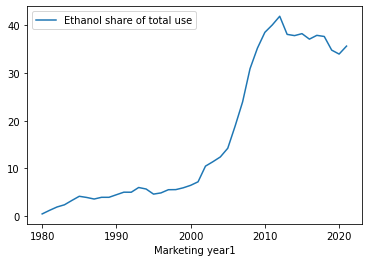

In [7]:
dated_df.plot(x='Marketing year1', y='Ethanol share of total use')

## Model generation
The data seems to follow a logistic regression curve, so those parameters will be used

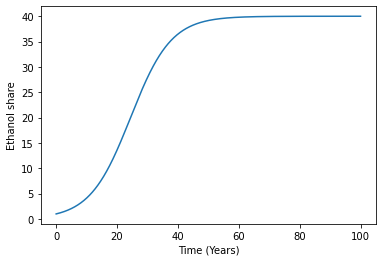

In [8]:
#logistic condition
def logistic (N,t, B, gamma):
    dNdt = gamma*N*(1-N/B)
    return dNdt

N0 = 1 # initial condition
B = 40 # carrying capacity
gamma = 0.15 # growth rate
dt = 0.1 # time step
t_total = 100 # total time


t = np.linspace(0, t_total, int(t_total/dt + 1))

N = odeint(logistic, N0, t, args = (B, gamma))

plt.plot(t, N)
plt.xlabel('Time (Years)')
plt.ylabel('Ethanol share')
plt.show()

Years will be shifted so values start at 0. Step necessary when dealing with linear functions

In [9]:
# Select values
years = dated_df[['Marketing year1']].to_numpy().flatten()
share=dated_df[['Ethanol share of total use']].to_numpy().flatten()
lvdata = np.array([years, share])
print(type(lvdata),lvdata.shape)


<class 'numpy.ndarray'> (2, 42)


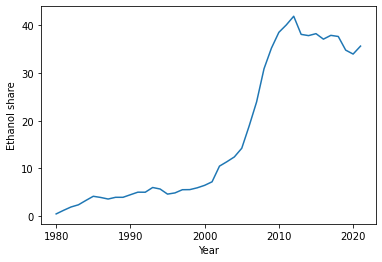

In [10]:
plt.plot(lvdata[0],lvdata[1])
plt.xlabel('Year')
plt.ylabel('Ethanol share')
plt.show()

In [11]:
#Parameter fitting

# define the error function (Sum of Square differences, SSD)
def error_ssd (p):
    
    X0 = lvdata[1,0] # initial condition
    a,b = p
    dt = 0.01 # time step
    t_total = lvdata.shape[1]-1 # total time
    steps_dt = int(1/dt)
    steps_total = int(t_total/dt)+1

    t = np.linspace(0, t_total, steps_total)
    X = odeint(logistic, X0, t, args = (a, b))
    data_sim = X[0:steps_total:steps_dt,]
    
    diff = lvdata[1,] - data_sim[:,0]
    error = np.dot(diff,diff)
    error= error/steps_total

    return error

In [12]:
## Fit data
p0 = [B,gamma]
res = minimize(error_ssd, p0, method='BFGS', tol=1e-6)

B,gamma = res.x
X0 = lvdata[1,0] # initial condition
dt = 1 # time step
t_total = 50 # total time
steps_dt = int(1/dt)
steps_total = int(t_total/dt)+1

t = np.linspace(0, t_total, steps_total)
X = odeint(logistic, X0, t, args = (B,gamma))


Text(0, 0.5, 'Ethanol share (%)')

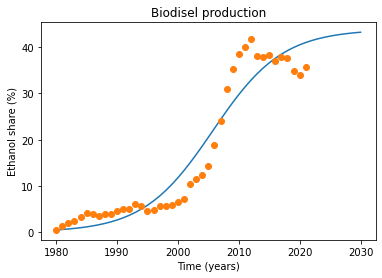

In [13]:
## Plot fitted data
plt.plot(t+lvdata[0,0], X[:,0], '', label="N(sim)")
plt.plot(lvdata[0,:], lvdata[1,:], 'o', label="N(data)")
plt.title('Biodisel production')
plt.xlabel('Time (years)')
plt.ylabel('Ethanol share (%)')

In [14]:
print(t+lvdata[0,0],X[:,0])
print(lvdata[0,:], lvdata[1,:])

[1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016. 2017. 2018. 2019. 2020. 2021. 2022. 2023. 2024. 2025. 2026. 2027.
 2028. 2029. 2030.] [ 0.48060788  0.5713075   0.67885605  0.80627356  0.95707671  1.13534204
  1.34576982  1.59374445  1.88538568  2.22758274  2.62800088  3.09504647
  3.63777384  4.26571437  4.98860802  5.81601763  6.75681343  7.81852527
  9.00658123 10.32347301 11.76792151 13.33414446 15.01134749 16.78356442
 18.62994386 20.52552906 22.4424984  24.35175    26.22464701 28.03470242
 29.75900205 31.37921073 32.8820903  34.25954041 35.50823951 36.6290019
 37.62597721 38.50580513 39.27681225 39.94830723 40.53000232 41.03156741
 41.46230853 41.83095338 42.14552411 42.41327725 42.64069247 42.8334953
 42.99670144 43.13467367 43.25118462]
[1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1

In [15]:
# Optimization info
#output: initial parameters, optimized parameters, initial error, final error
p0, res.x, error_ssd(p0), error_ssd(res.x)

([40, 0.15],
 array([43.87092487,  0.17496839]),
 0.5073135511417461,
 0.17747283530455418)

In [16]:
# Test accuracy
original_data=lvdata[1,:].flatten()
sim_data = X[0:original_data.shape[0]].flatten()

diff= original_data-sim_data
np.sum(np.square(diff))/original_data.shape[0]

17.328954185629808